<a href="https://colab.research.google.com/github/balirohan/Human-Emotion-Detection/blob/main/MobileNet_V2_90_93_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'human-emotions-datasethes:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1830888%2F2996867%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240521%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240521T191535Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D411b5285b6a2f687cc0baff09accdefc41814fb0f6843b8ab323836750e2c4de2a58668cb1640c1a1147c6dd87b036d6d0a5d4182973018983708996bc47157e5278f6c69163d00ae5fc2e91183fdfd30dde16e45d7df1411d9a2831f4b73717dc813deaeb5e136e966a1307aac156d99730497da6786508c55a6a5a1728d9f5fbd92b4a061f3e004f8f630cc0b45480cdeaa4ffa14eb33c71df724701c57e553b14b2926fc36e5a21898baecb0b9206cbd6665afe4066420ef1d4e843dff93fe7045573bc52b53afa2050e320eca2f1fd1604c17bd8de946c3c7620c4ea5f15b928bb8fa341e26a168ded39e07e64306731f2f09484983cd79eb6049aae77e6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 324440157 bytes downloaded
Downloaded and uncompressed: human-emotions-datasethes
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
!pip install tensorflow-addons

In [ ]:
# !pip install tensorflow
import tensorflow_addons as tfa

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu,True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
source_dir1 = '/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train'
source_dir2 = '/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test'

In [ ]:
merged_dir = "merged_dataset"

In [ ]:
os.makedirs(merged_dir, exist_ok=True)

In [ ]:
def copy_files(source_dir, dest_dir):
    for root, _, files in os.walk(source_dir):
        for file in files:
            # Determine the original subfolder (class) name
            class_name = os.path.basename(root)
            class_dir = os.path.join(dest_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)

            # Create a unique file path to avoid conflicts
            dest_file_path = os.path.join(class_dir, file)

            # If there's a conflict, append a unique identifier
            if os.path.exists(dest_file_path):
                file_name, file_extension = os.path.splitext(file)
                unique_name = f"{file_name}_from_{os.path.basename(source_dir)}{file_extension}"
                dest_file_path = os.path.join(class_dir, unique_name)

            shutil.copy(os.path.join(root, file), dest_file_path)

In [ ]:
copy_files(source_dir1, merged_dir)
copy_files(source_dir2, merged_dir)

print("Directories merged successfully!")

Directories merged successfully!


In [ ]:
train_dir = "train_set"
valid_dir = "valid_set"
test_dir = "test_set"

In [ ]:
for directory in [train_dir, valid_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

In [ ]:
import random
from sklearn.model_selection import train_test_split

In [ ]:
for class_name in os.listdir(merged_dir):
    class_path = os.path.join(merged_dir, class_name)

    # Get the list of files in the class
    file_names = os.listdir(class_path)

    # Shuffle the files to ensure random distribution
    random.shuffle(file_names)

    # Split into training (70%), validation (15%), and test (15%)
    train_files, temp_files = train_test_split(file_names, test_size=0.1, random_state=42)
    valid_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Function to copy files to a destination directory
    def copy_to_dest(files, source_class_path, dest_dir):
        dest_class_dir = os.path.join(dest_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)

        for file in files:
            shutil.copy(os.path.join(source_class_path, file), os.path.join(dest_class_dir, file))

    # Copy the files to their respective directories
    copy_to_dest(train_files, class_path, train_dir)
    copy_to_dest(valid_files, class_path, valid_dir)
    copy_to_dest(test_files, class_path, test_dir)

print("Training, validation, and test sets created successfully!")

Training, validation, and test sets created successfully!


In [ ]:
datagen = ImageDataGenerator(validation_split=0.3
                             ,brightness_range=[0.8, 1.2]
                            #  ,zoom_range=0.2
                            #  , rotation_range=30
                             )

In [ ]:
train_dataset = datagen.flow_from_directory(
    directory='/content/train_set',
    target_size=(192,192),
    class_mode='categorical',
    subset='training',
    batch_size=64
)

Found 12618 images belonging to 3 classes.


In [ ]:
valid_dataset = datagen.flow_from_directory(
    directory='/content/valid_set',
    target_size=(192,192),
    class_mode='categorical',
    subset='validation',
    batch_size=64
)

Found 1020 images belonging to 3 classes.


In [ ]:
test_dataset = ImageDataGenerator().flow_from_directory(
    directory='/content/test_set',
    target_size=(192, 192),
    class_mode='categorical',
    batch_size=64
)

Found 3387 images belonging to 3 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(192,192,3),include_top=False,weights="imagenet")

In [ ]:
total_layers = len(base_model.layers)

In [ ]:
num_layers_to_freeze = total_layers // 4

In [ ]:
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_4, Trainable: False
Layer 1: Conv1, Trainable: False
Layer 2: bn_Conv1, Trainable: False
Layer 3: Conv1_relu, Trainable: False
Layer 4: expanded_conv_depthwise, Trainable: False
Layer 5: expanded_conv_depthwise_BN, Trainable: False
Layer 6: expanded_conv_depthwise_relu, Trainable: False
Layer 7: expanded_conv_project, Trainable: False
Layer 8: expanded_conv_project_BN, Trainable: False
Layer 9: block_1_expand, Trainable: False
Layer 10: block_1_expand_BN, Trainable: False
Layer 11: block_1_expand_relu, Trainable: False
Layer 12: block_1_pad, Trainable: False
Layer 13: block_1_depthwise, Trainable: False
Layer 14: block_1_depthwise_BN, Trainable: False
Layer 15: block_1_depthwise_relu, Trainable: False
Layer 16: block_1_project, Trainable: False
Layer 17: block_1_project_BN, Trainable: False
Layer 18: block_2_expand, Trainable: False
Layer 19: block_2_expand_BN, Trainable: False
Layer 20: block_2_expand_relu, Trainable: False
Layer 21: block_2_depthwise, Trainable: False


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization_3 (Bat  (None, 6, 6, 1280)        5120      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2266947 (8.65 MB)
Trainable params: 2197955 (8.38 MB)
Non-trainable params: 68992 (269.50 KB)
____________

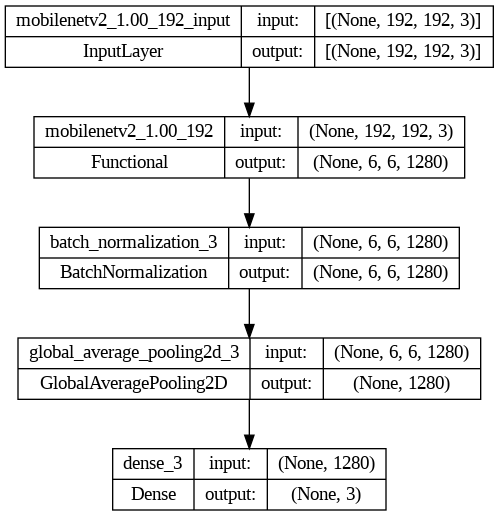

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


In [ ]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=3, name='f1_score')
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=10)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 40,verbose = 1,callbacks=[mcp,es])

Epoch 1/40
198/198 [==============================] - ETA: 0s - loss: 0.6069 - accuracy: 0.7412 - precision: 0.7904 - recall: 0.6834 - auc: 0.9028 - f1_score: 0.7199

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 66s 219ms/step - loss: 0.6069 - accuracy: 0.7412 - precision: 0.7904 - recall: 0.6834 - auc: 0.9028 - f1_score: 0.7199 - val_loss: 4.5031 - val_accuracy: 0.2265 - val_precision: 0.2265 - val_recall: 0.2265 - val_auc: 0.4653 - val_f1_score: 0.1231
Epoch 2/40
198/198 [==============================] - 33s 167ms/step - loss: 0.3310 - accuracy: 0.8691 - precision: 0.8942 - recall: 0.8478 - auc: 0.9706 - f1_score: 0.8573 - val_loss: 5.4416 - val_accuracy: 0.2265 - val_precision: 0.2265 - val_recall: 0.2265 - val_auc: 0.4412 - val_f1_score: 0.1232
Epoch 3/40
198/198 [==============================] - 34s 172ms/step - loss: 0.2434 - accuracy: 0.9076 - precision: 0.9212 - recall: 0.8948 - auc: 0.9838 - f1_score: 0.8983 - val_loss: 10.1816 - val_accuracy: 0.3735 - val_precision: 0.3735 - val_recall: 0.3735 - val_auc: 0.5448 - val_f1_score: 0.3057
Epoch 4/40
198/198 [==============================] - 34s 171ms/step - loss: 0.1584 - accuracy: 0.9398 - pr

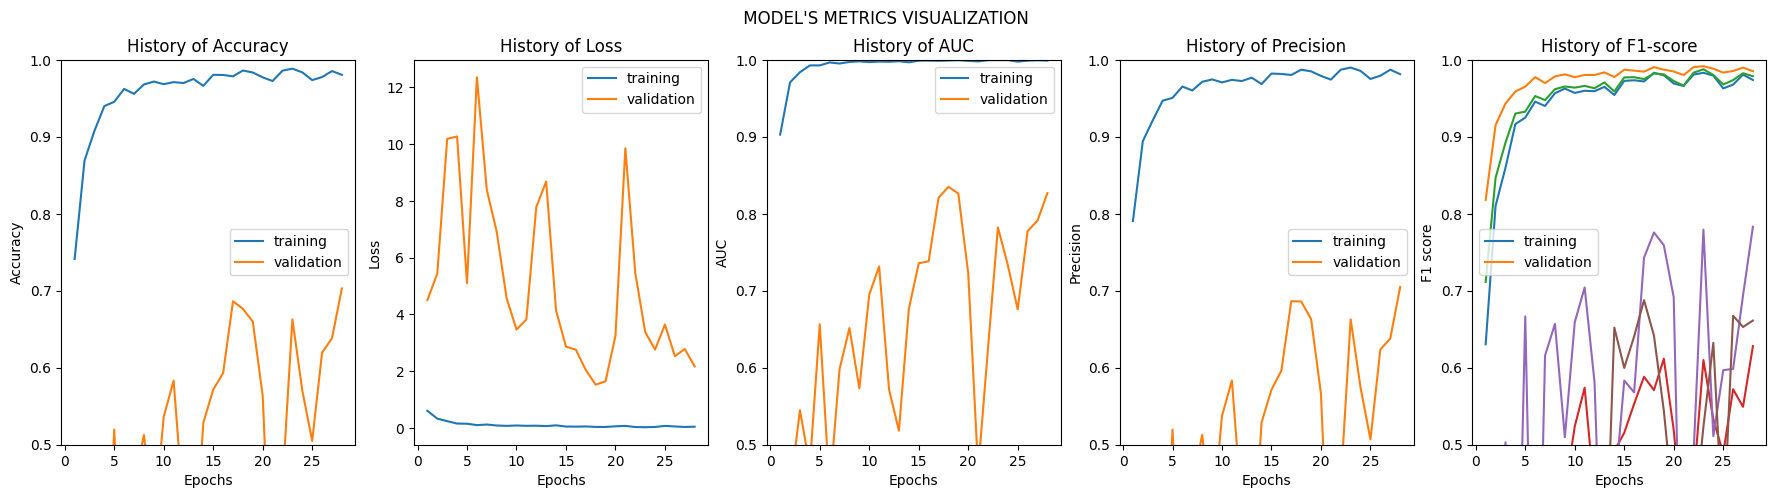

In [ ]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(22, 5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    # Rescale the y-axis for accuracy, auc, precision, and f1
    rescale_factor = 0.5  # Adjust this factor to control the rescaling

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0.5, 1.0])
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.set_ylim([rescale_factor, 1.0])
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.set_ylim([rescale_factor, 1.0])
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.set_ylim([rescale_factor, 1.0])
    ax5.legend(['training', 'validation'])

    plt.show()

# Example usage:
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])


In [ ]:
test_results = model.evaluate(test_dataset)

53/53 [==============================] - 6s 118ms/step - loss: 0.8956 - accuracy: 0.8406 - precision: 0.8436 - recall: 0.8391 - auc: 0.9343 - f1_score: 0.8284


In [ ]:
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = test_dataset.classes

conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

53/53 [==============================] - 5s 81ms/step
Confusion Matrix:
[[224 332 210]
 [429 630 435]
 [307 516 304]]


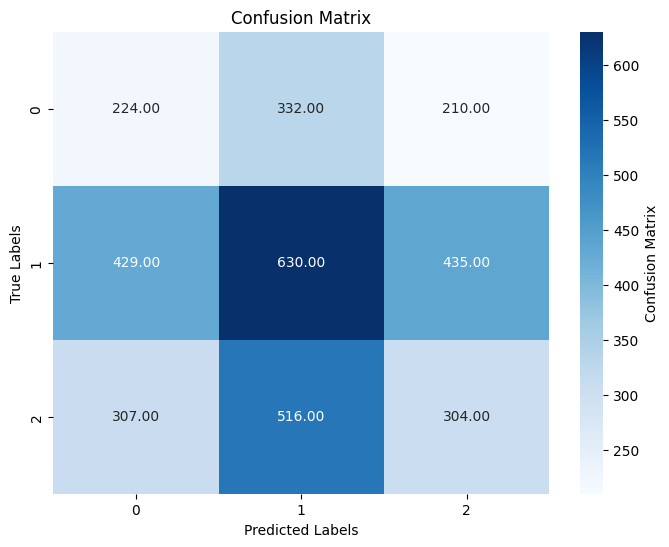

In [ ]:
import seaborn as sns

# # Assuming conf_matrix is the confusion matrix obtained previously
# class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# # Normalize the confusion matrix
# conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# # Create a DataFrame for better visualization
# conf_df = pd.DataFrame(conf_matrix_norm, index=class_names, columns=class_names)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt=".2f", cbar_kws={'label': 'Confusion Matrix'})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
class_names = ['Angry', 'Happy', 'Sad']
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       Angry       0.23      0.29      0.26       766
       Happy       0.43      0.42      0.42      1494
         Sad       0.32      0.27      0.29      1127

    accuracy                           0.34      3387
   macro avg       0.33      0.33      0.33      3387
weighted avg       0.35      0.34      0.34      3387

